In [1]:
import sys
import os
import time

from multiprocess import Pool
import numpy as np
from scipy.ndimage.interpolation import map_coordinates

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *

Setting environment for Precision WorkStation


No vtk
No vtkNot using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.


In [2]:
from registration_utilities import *
from annotation_utilities import *

In [3]:
%matplotlib inline

In [4]:
def contours_to_mask(contours, img_shape):
    """
    Fill the contours.
    
    Returns:
        binary mask
    """
    w, h = img_shape
    bg = np.zeros((h, w), np.bool)
    for cnt in contours:
        xys = points_in_polygon(cnt)
        bg[xys[:,1], xys[:,0]] = 1
    return bg

In [5]:
def draw_contour_lines(im, sm, levels):
    viz = img_as_ubyte(gray2rgb(im))
    for level in levels:
        sm_padded = np.pad(sm, 10, mode='constant', constant_values=0)
        yx_cnts = find_contours(sm_padded, level)
        mask = contours_to_mask([yx_cnt[:, ::-1].astype(np.int) for yx_cnt in yx_cnts], sm_padded.shape[::-1])
        xy_cnts_alllabels = find_contour_points(mask, sample_every=1)
        if len(xy_cnts_alllabels) == 0:
            continue
        
        xy_cnts = xy_cnts_alllabels[1]
        
        for xy_cnt in xy_cnts:
            cv2.polylines(viz, [xy_cnt.astype(np.int) - (10,10)], isClosed=True, 
                          color=np.array(plt.cm.jet((np.float(level-levels.min())/(levels.max()-levels.min())))[:4])*255, thickness=1)
#         for yx_cnt in yx_cnts:
#             cv2.polylines(viz, [yx_cnt[:,::-1].astype(np.int)], isClosed=True, 
#                           color=np.array(plt.cm.jet(level)[:3])*255, thickness=1)
    return viz

In [4]:
# stack = 'MD589'
# stack = 'MD590'
# stack = 'MD591'
stack = 'MD592'
detector_id = 15
downscale = 8
#input_img_version = args.input_img_version

detector_properties = detector_settings.loc[detector_id]
windowing_id = int(detector_properties['windowing_id'])
#model_name = detector_properties['feature_network']
#classifier_id = int(detector_properties['feature_classifier_id'])

#classifier_properties = classifier_settings.loc[classifier_id]
#model_name = dataset_settings.loc[int(classifier_settings.loc[classifier_id]['train_set_id'].split('/')[0])]['network_model']

# patch_size, spacing, w, h = get_default_gridspec(stack)
windowing_properties = windowing_settings[windowing_id]
patch_size = windowing_properties['patch_size']
spacing = windowing_properties['spacing']
w, h = metadata_cache['image_shape'][stack]

half_size = patch_size/2

In [5]:
# fn = 'MD589-IHC40-2015.07.31-00.02.21_MD589_2_0119'
# fn = 'MD590-N46-2015.08.03-20.05.19_MD590_3_0136'
# fn = 'MD591-IHC44-2015.08.28-06.07.20_MD591_2_0131'
fn = 'MD592-IHC46-2015.08.25-23.08.46_MD592_1_0136'

In [6]:
im = DataManager.load_image_v2(stack, prep_id=2, version='jpeg', fn=fn)

Not using image_cache.


In [7]:
# 12N
# ymin = 1900/2
# ymax = 2500/2
# xmin = 1250
# xmax = 1600

# MD590-N46-2015.08.03-20.05.19_MD590_3_0136
# 12N
# xmin = 10449
# ymin = 8283
# xdim = 2042
# ydim = 1320

# MD591-IHC44-2015.08.28-06.07.20_MD591_2_0131'
# 12N
# xmin = 8906
# ymin = 9009
# xdim = 4206
# ydim = 2314
# 12N new
# xmin = 8763
# ymin = 8416
# xdim = 4832
# ydim = 2304

#3N
# xmin = 3050
# ymin = 4786
# xdim = 2522
# ydim = 1513

# MD592-IHC46-2015.08.25-23.08.46_MD592_1_0136
# 12N
# xmin = 8619
# ymin = 7576
# xdim = 4922
# ydim = 1328
# 12N new
xmin = 8864
ymin = 6976
xdim = 4832
ydim = 2304

# 3N
# xmin = 1542
# ymin = 5586
# xdim = 3534
# ydim = 1137
# To make regions from two images the same size
# xmin = 2496
# ymin = 5344
# xdim = 2522
# ydim = 1513
# To make region larger
# xmin = 2096
# ymin = 4944
# xdim = 3322
# ydim = 2513

xmax = xmin + xdim - 1
ymax = ymin + ydim - 1

In [13]:
xmin = xmin/downscale
ymin = ymin/downscale
xmax = xmax/downscale
ymax = ymax/downscale

In [8]:
try:
    _, sample_locations_roi = DataManager.load_patch_locations(stack=stack, fn=fn, win=windowing_id)
except Exception as e:
    sys.stderr.write('Error loading patch locations for %s: %s.\n' % (fn, str(e)))

downscaled_grid_y = np.arange(0, h, downscale)
downscaled_grid_x = np.arange(0, w, downscale)
downscaled_ny = len(downscaled_grid_y)
downscaled_nx = len(downscaled_grid_x)

rm -rf "/media/yuncong/BstemAtlasData/CSHL_patch_locations/MD592/MD592_prep2_gray_win5/MD592-IHC46-2015.08.25-23.08.46_MD592_1_0136_prep2_gray_win5_patchLocations.txt" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_patch_locations/MD592/MD592_prep2_gray_win5"
aws s3 cp "s3://mousebrainatlas-data/CSHL_patch_locations/MD592/MD592_prep2_gray_win5/MD592-IHC46-2015.08.25-23.08.46_MD592_1_0136_prep2_gray_win5_patchLocations.txt" "/media/yuncong/BstemAtlasData/CSHL_patch_locations/MD592/MD592_prep2_gray_win5/MD592-IHC46-2015.08.25-23.08.46_MD592_1_0136_prep2_gray_win5_patchLocations.txt"


In [9]:
im2 = im[::downscale, ::downscale][ymin:ymax+1, xmin:xmax+1]

In [10]:
# imbg = im2
imwhite = 0 * np.ones((im2.shape[0], im2.shape[1],4), np.uint8)

In [32]:
# for structure in ['AP', '12N', '10N']:
for structure in ['3N']:
# for structure in ['12N']:

    try:
        sparse_scores = DataManager.load_sparse_scores(stack, fn=fn, structure=structure, detector_id=detector_id)
    except Exception as e:
        sys.stderr.write('Error loading sparse scores for %s: %s\n' % (structure, str(e)))

    f_grid = np.zeros(((h-half_size)/spacing+1, (w-half_size)/spacing+1))
    a = (sample_locations_roi - half_size)/spacing
    f_grid[a[:,1], a[:,0]] = sparse_scores

    yinterps = (downscaled_grid_y - half_size)/float(spacing)
    xinterps = (downscaled_grid_x - half_size)/float(spacing)

    points_y, points_x = np.broadcast_arrays(yinterps.reshape(-1,1), xinterps)
    coord = np.c_[points_y.flat, points_x.flat]
    f_interp = map_coordinates(f_grid, coord.T, order=1)
    dense_scoremap = f_interp.reshape((downscaled_ny, downscaled_nx))
    
    dense_scoremap_roi = dense_scoremap[ymin:ymax+1, xmin:xmax+1]

    viz = draw_contour_lines(imwhite, 
                         dense_scoremap_roi,
                        levels=np.arange(0.1,1.1,.1))

#     plt.figure(figsize=(20,20))
#     plt.imshow(viz)
#     plt.show();

#     imsave('/home/yuncong/%s.png' % structure, viz)

In [33]:
imsave('/home/yuncong/highres.png', im2)

In [12]:
# im_g = img_as_ubyte(gaussian(rgb2gray(im2), sigma=3)) # sigma=3 correspond to 25um
im_g = img_as_ubyte(gaussian(rgb2gray(im2), sigma=6)) # sigma=6 correspond to 50um

/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


In [35]:
imsave('/home/yuncong/gaussian.png', im_g)

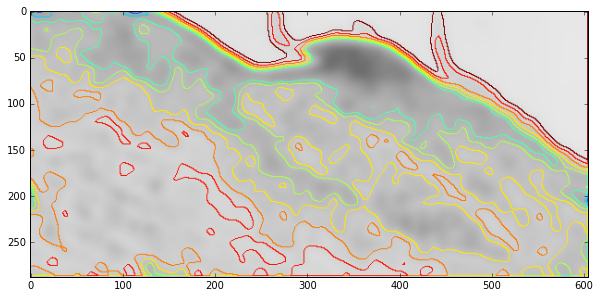

In [17]:
# viz = draw_contour_lines(imwhite, im_g, levels=[120, 130, 140, 150,160, 170, 180]);
# viz = draw_contour_lines(im_g, im_g, levels=np.linspace(160, 220, 10)); #592 3N
# viz = draw_contour_lines(im_g, im_g, levels=np.linspace(130, 220, 10)); #591 3N
# viz = draw_contour_lines(im_g, im_g, levels=np.linspace(100, 220, 10)); #592 12N
viz = draw_contour_lines(im_g, im_g, levels=np.linspace(150, 220, 10)); #591 12N

plt.figure(figsize=(10, 10))
plt.imshow(viz, cmap=plt.cm.gray)
plt.show();

In [18]:
imsave('/home/yuncong/gaussian_contours.png', viz)

In [19]:
# viz = draw_contour_lines(gray2rgb(im_g), im_g, levels=[200]);

# plt.figure(figsize=(20,20));
# plt.imshow(viz, cmap=plt.cm.gray);
# plt.show();

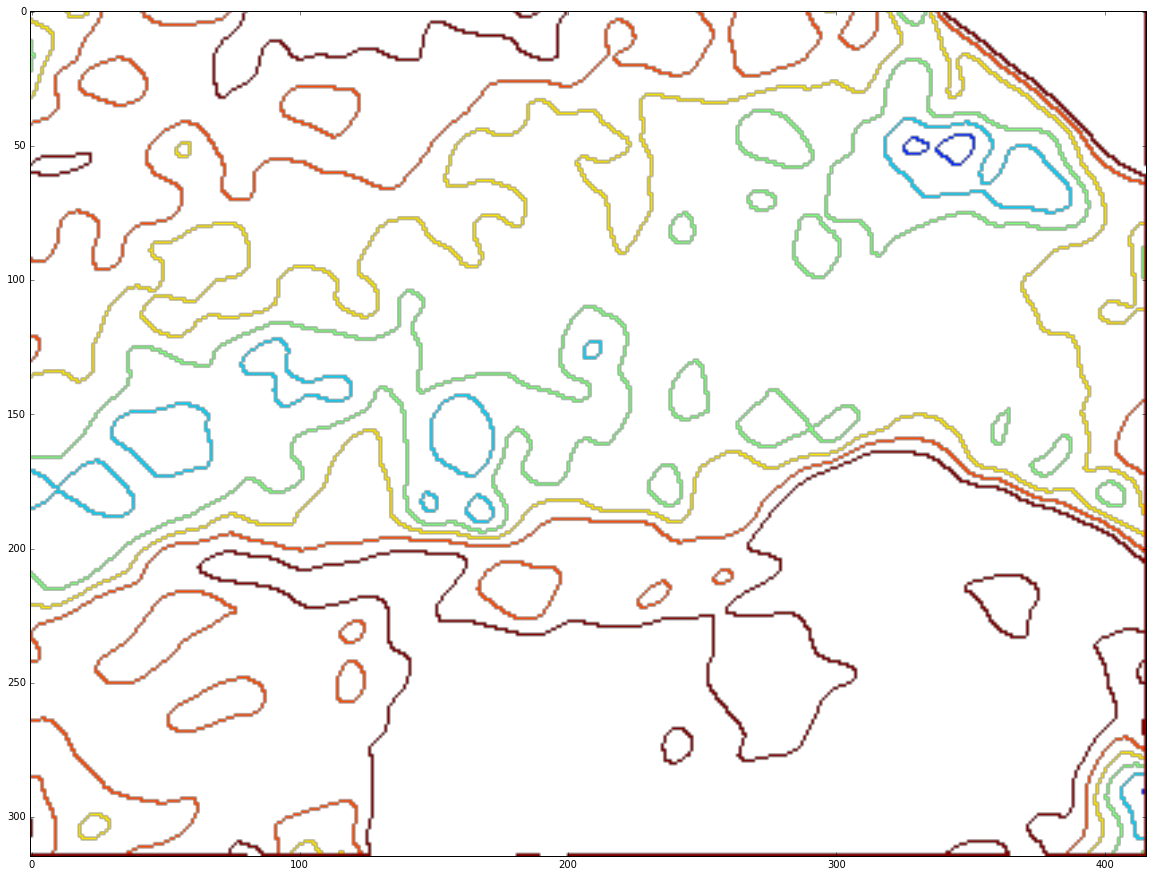

In [36]:
viz = np.zeros(im_g.shape[:2] + (4,), np.uint8)
levels = np.array([120., 130., 140., 150., 160., 170., 180.])
# levels = np.array([170., 180., 190., 200., 210., 220.])
# levels = np.arange(90,255,20)
for level in levels:
    try:
        xy_cnts = find_contour_points(im_g < level, sample_every=1)[1]
        for i, xy_cnt in enumerate(xy_cnts):
            viz[xy_cnt[:,1].astype(np.int), xy_cnt[:,0].astype(np.int)] = img_as_ubyte(plt.cm.jet((level-np.min(levels))/(np.max(levels)-np.min(levels))))
    except:
        pass
            
plt.figure(figsize=(20,20))
plt.imshow(viz, cmap=plt.cm.gray)
plt.show();

In [21]:
imsave('/home/yuncong/gaussian_contours.png', viz)

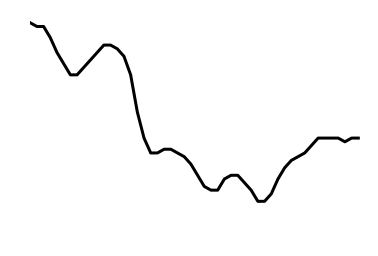

In [13]:
# MD592 12N new
# e1 = np.array((291, 249))
# e2 = np.array((367, 49))
# MD591 12N
# e1 = np.array((301, 260))
# e2 = np.array((425, 89))
# MD592 3N_newlarge
e1 = np.array((218, 243))
e2 = np.array((210, 77))
sample_points = np.c_[np.linspace(e1[0], e2[0], 50), np.linspace(e1[1], e2[1], 50)].astype(np.int)
# plt.plot(dense_scoremap_roi[sample_points[:,1], sample_points[:,0]], c='r', lw=3);
plt.plot(im_g[sample_points[:,1], sample_points[:,0]], c='k', lw=3);
plt.axis('off');

# New

In [32]:
stack = 'MD592'
name_s = '12N'
# name_s = '3N_L'

In [33]:
if stack == 'MD589':
    fn = 'MD589-IHC40-2015.07.31-00.02.21_MD589_2_0119'
    # 12N
    # ymin = 1900/2
    # ymax = 2500/2
    # xmin = 1250
    # xmax = 1600

elif stack == 'MD590':
    fn = 'MD590-N46-2015.08.03-20.05.19_MD590_3_0136'
    # 12N
    # xmin = 10449
    # ymin = 8283
    # xdim = 2042
    # ydim = 1320

elif stack == 'MD591':

    fn = 'MD591-IHC44-2015.08.28-06.07.20_MD591_2_0131'
    # 12N
    # xmin = 8906
    # ymin = 9009
    # xdim = 4206
    # ydim = 2314
    # 12N new
    # xmin = 8763
    # ymin = 8416
    # xdim = 4832
    # ydim = 2304

    #3N
    # xmin = 3050
    # ymin = 4786
    # xdim = 2522
    # ydim = 1513

elif stack == 'MD592':
    fn = 'MD592-IHC46-2015.08.25-23.08.46_MD592_1_0136'

    if convert_to_original_name(name_s) == '3N':
        # 3N
        # xmin = 1542
        # ymin = 5586
        # xdim = 3534
        # ydim = 1137
        # To make regions from two images the same size
        # xmin = 2496
        # ymin = 5344
        # xdim = 2522
        # ydim = 1513
        # To make region larger
        xmin = 2096
        ymin = 4944
        xdim = 3322
        ydim = 2513
    elif convert_to_original_name(name_s) == '12N':
        # 12N
        # xmin = 8619
        # ymin = 7576
        # xdim = 4922
        # ydim = 1328
        # 12N new
        xmin = 8864
        ymin = 6976
        xdim = 4832
        ydim = 2304
    else:
        raise


xmax = xmin + xdim - 1
ymax = ymin + ydim - 1
im = DataManager.load_image_v2(stack, prep_id=2, version='jpeg', fn=fn)

Not using image_cache.


In [34]:
from sklearn.externals import joblib
clf = joblib.load('/tmp/%s_gray_clf.clf' % convert_to_original_name(name_s))

In [35]:
im_g_roi = img_as_ubyte(gaussian(rgb2gray(im[ymin:ymax+1, xmin:xmax+1]), sigma=100))

In [36]:
from learning_utilities import *

In [37]:
viz, sm = draw_scoremap(clf=clf, structure=name_s, 
                        scheme='none',
                        bbox=(xmin, xmax, ymin, ymax), 
                        stack=stack, fn=fn,
                        bg_img_local_region=im_g_roi,
                       return_scoremap=True, 
                       feature='mean')

locate patches: 0.02 seconds
Not using image_cache.
Load image: 22.03 seconds.
Extract patches: 22.14 seconds


(288, 604, 3) (288, 604)


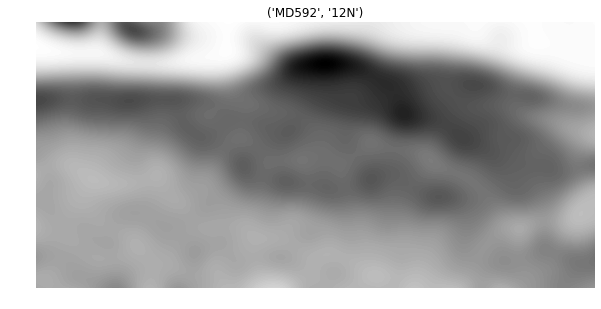

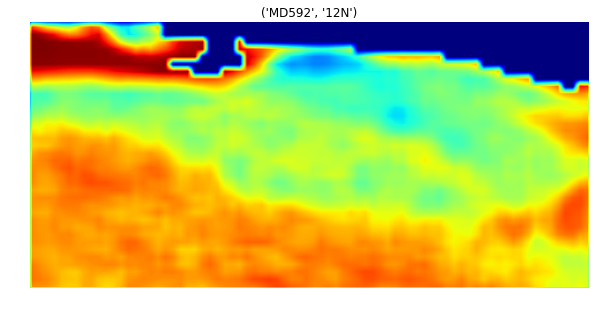

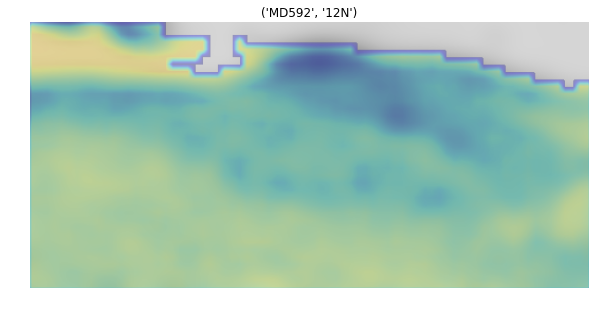

In [42]:
plt.figure(figsize=(10, 10));
plt.imshow(im_g_roi, cmap=plt.cm.gray);
plt.axis('off');
plt.title((stack, name_s));
plt.show();

plt.figure(figsize=(10, 10));
plt.imshow(sm);
plt.axis('off');
plt.title((stack, name_s));
plt.show();

plt.figure(figsize=(10, 10));
plt.imshow(viz);
plt.axis('off');
plt.title((stack, name_s));
plt.show();

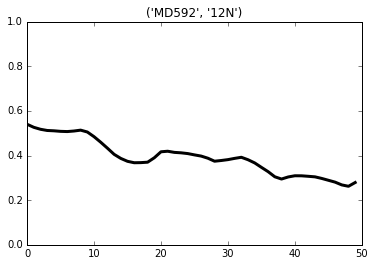

In [43]:
# Profile line coordinates are relative to cropped images.
if stack == 'MD592':
    if name_s == '12N':
        # MD592 12N new
        e1 = np.array((291, 249))
        e2 = np.array((367, 49))
    elif name_s == '3N_L':
        # MD592 3N_newlarge
        e1 = np.array((218, 243))
        e2 = np.array((210, 77))
else:
    pass
    # MD591 12N
    # e1 = np.array((301, 260))
    # e2 = np.array((425, 89))

sample_points = np.c_[np.linspace(e1[0], e2[0], 50), np.linspace(e1[1], e2[1], 50)].astype(np.int)
# plt.plot(dense_scoremap_roi[sample_points[:,1], sample_points[:,0]], c='r', lw=3);
plt.plot(sm[sample_points[:,1], sample_points[:,0]], c='k', lw=3);
plt.ylim([0,1]);
plt.title((stack, name_s));
# plt.axis('off');